# Example maingopy BO with global acquisition function optimization

From melon (https://git.rwth-aachen.de/avt-svt/public/MeLOn/-/tree/master/gaussian%20process), maingopy (https://git.rwth-aachen.de/avt-svt/public/maingo/-/tree/master/examples/05_GaussianProcess) and the GP paper (https://arxiv.org/pdf/2005.10902.pdf).

Same problem statement as the ANN one. 

GP resources: http://gpss.cc/gpss20/

GP bible: http://www.gaussianprocess.org/gpml/chapters/RW.pdf

BO tutorial included in gpss labs.

In [1]:
import utils
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from pyDOE import lhs
import torch
import gpytorch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import maingopy
import random
import warnings
import os

Implement peaks function

In [2]:
def peaks(X):
    term1 = 3*np.multiply((1-X[:,0])**2, np.exp(-(X[:,0])**2-(X[:,1]+1)**2))
    term2 = np.multiply(-10*(X[:,0]/5-X[:,0]**3-X[:,1]**5), np.exp(-X[:,0]**2-X[:,1]**2))
    term3 = -np.exp(-(X[:,0]+1)**2-X[:,1]**2)/3
    y = term1 + term2 + term3
    return np.expand_dims(y, axis=-1)

In [3]:
# test global minimum at f(0.228, -1.626)=-6.551
peaks(np.array([[0.228, -1.626], [0.5,0.5]]))

array([[-6.55112995],
       [ 0.37537558]])

## Training data generation

Generate 10 samples with latin hypercube sampling, rescale to [-3, 3] and evaluate.

In [4]:
INIT_SAMPLES = 10
lhd = lhs(2, samples=INIT_SAMPLES)
Xpeaks = lhd*6-3
ypeaks = peaks(Xpeaks)

In [5]:
# scale data and retain information to do ivnerse in the scaler object
scaler = dict()

# scale inputs to [0 , 1]
scaler['input'] = MinMaxScaler(feature_range=(0,1)) 
Xscaled = scaler['input'].fit_transform(Xpeaks)

# scale outputs to zero mean and unit variance
scaler['output'] = StandardScaler()
yscaled = scaler['output'].fit_transform(ypeaks.reshape(-1, 1)).squeeze()

## Load and set parameters

In [6]:
problem_name = 'peaks'
# dimensionality of the data
input_dim = 2
output_dim = 1
# scale Input to [-1,1] range
scaleInput = True
# normalize Output to z-score
normalizeOutput = True

## Set model parameters

In [7]:
# output filename
output_folder = "./data/GP/"
filename_out = output_folder + problem_name
# training parameters
MATERN = 5 # matern 5/2 covariance function

#learning parameters
N_TRAINING_ITER = 500
LR = 0.08
WD = 0.1

## Build GP

In [8]:
#Traning data to torch
Xtrain = torch.from_numpy(Xscaled)
ytrain = torch.from_numpy(yscaled)

Model: exact GP with a marginal log likelihood, matern 5/2 covariance function and constant mean. 

In [9]:
class ExactGPModel(gpytorch.models.ExactGP): #definition of class
    def __init__(self, train_x, train_y, likelihood, matern): # def creates objects needed for forward
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        #super() returns a proxy class which inherits gpytorch.models.ExactGP, its parent
        #in short, we create a subclass by extending the parent
        self.mean_module = gpytorch.means.ConstantMean() # constant mean
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=matern/2, ard_num_dims = 2)
            )
        #self.covar_module = gpytorch.kernels.MaternKernel(nu=matern/2, ard_num_dims = 2) #matern class
        #we have flexible options for mean and covar module definition (i.e. with/without white noise, here or below
        
    def forward(self, x): #computes 
        mean_x = self.mean_module(x) #prior mean
        covar_x = self.covar_module(x)# + self.white_noise_module(x) #prior covariance matrix from kernels
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) #multivar normal

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(Xtrain.float(), ytrain.squeeze().float(), likelihood, matern=MATERN)

In [11]:
ytrain.squeeze().float()

tensor([ 0.4896, -0.1125, -0.0773,  0.4608,  1.3309, -0.0569,  0.6143, -0.0919,
         0.1533, -2.7103])

## Train with adam

First-order gradient-based optimization of stochastic objective functions (https://arxiv.org/abs/1412.6980)

In [12]:
def trainGP(model, likelihood, N_TRAINING_ITER, print_iter=True):
    training_time = time.time()

    # Find optimal model hyperparameters, put modle in training
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(N_TRAINING_ITER):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(*model.train_inputs)
        # Calc loss and backprop gradients
        loss = -mll(output, model.train_targets)
        loss.backward()
        if (i+1)%25 == 0 and print_iter:
            print('Iter %d/%d \n\tLoss:\t%s\n\tlengthscale:\t%s\n\tnoise:\t%s' % (
                i + 1, N_TRAINING_ITER, loss,
                model.covar_module.base_kernel.lengthscale,
                model.likelihood.noise
            ))
        optimizer.step()

    training_time = training_time - time.time()
    
    return [model, likelihood]

In [13]:
[model, likelihood] = trainGP(model, likelihood, N_TRAINING_ITER)

Iter 25/500 
	Loss:	tensor(1.5137, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.7894, 0.5741]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.8424], grad_fn=<AddBackward0>)
Iter 50/500 
	Loss:	tensor(1.5080, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.7477, 0.5509]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.8738], grad_fn=<AddBackward0>)
Iter 75/500 
	Loss:	tensor(1.5060, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.7510, 0.5411]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.8824], grad_fn=<AddBackward0>)
Iter 100/500 
	Loss:	tensor(1.5059, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.7492, 0.5421]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.8794], grad_fn=<AddBackward0>)
Iter 125/500 
	Loss:	tensor(1.5058, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.7489, 0.5419]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.8794], grad_fn=<AddBackward0>)
Iter 150/500 
	Loss:	tensor(1.5059, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.7490, 0.5419]], grad_fn

## Plot surrogate model

In [14]:
def compute_grid(lb, ub, npoints = 200):
    """computes peaks output in a grid to plot it"""
    vector1 = np.linspace(lb[0], ub[0], npoints)
    vector2 = np.linspace(lb[1], ub[1], npoints)
    test_grid_x1, test_grid_x2 = np.meshgrid(vector1, vector2)

    # positions = np.vstack([test_grid_x1.ravel(), test_grid_x2.ravel()])
    #np_test_x = (np.array(positions)).T
    #convert meshgrid to all possible pairwise combinations and input into the prediction model
    np_test_x = np.array([test_grid_x1, test_grid_x2]).T.reshape(-1,2)

    X_plot = test_grid_x2.reshape(np.size(test_grid_x2))
    Y_plot = test_grid_x1.reshape(np.size(test_grid_x1))
    
    return np.concatenate((np.expand_dims(X_plot, axis=-1), np.expand_dims(Y_plot, axis=-1)), axis=-1)

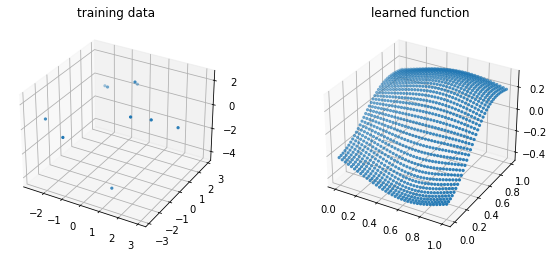

In [15]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GPplot = compute_grid(lb=[0,0], ub=[1, 1], npoints = 35)
X_plot = torch.cat((torch.from_numpy(GPplot[:,0]).unsqueeze(-1), torch.from_numpy(GPplot[:,1]).unsqueeze(-1)), axis=-1)
f_preds = model(X_plot.float()) #mean of the model
y_preds = likelihood(model(X_plot.float())) # covariance of the model at X_plot

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
cmap = plt.get_cmap('coolwarm')
ax.scatter(Xpeaks[:,0], Xpeaks[:,1], ypeaks, marker=".")
ax.set_title('training data')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(GPplot[:,0], GPplot[:,1], y_preds.mean.detach().squeeze().numpy(), marker=".")
ax.set_title('learned function')
plt.show()

## Define optimization problem in maingopy

In the same way as ANN. i.e.: define the GP and the acquisition function (in this case expected improvement (EI)) with melonpy, which gives the relaxations. Then pass on to maingopy which solves it globally with B&B in reduced space to find the next candidate and finally evaluate. Then start the loop again

Convert model to be readable by melonpy. Essentially: a dictionary containing the trained hyperparameters (lenghtscales and input scaler), the training inputs and the scaler information, which is min and max of training data, mean and std dev of training data to normalize.


In [16]:
gp_model = utils.generate_melon_gp_object(model, Xtrain, ytrain, MATERN, scaler)
#alternatively: pass information as a json file.
utils.save_model_to_json(r"./data/GP", "testGP.json", model, Xtrain, ytrain, MATERN, scaler)

In [17]:
class MaingoEI(maingopy.MAiNGOmodel):
        """maingopy.MAiNGOmodel child class which the acquisition function of expected improvement 
        for continuous variables.
        """
        
        def __init__(self, gp_data, kappa = 2):
            super(MaingoEI, self).__init__()
            self.lb = gp_data.inputScalerData.parameters.get(
                    maingopy.melonpy.SCALER_PARAMETER.LOWER_BOUNDS
                    ) # problem lower bounds
            self.ub = gp_data.inputScalerData.parameters.get(
                    maingopy.melonpy.SCALER_PARAMETER.UPPER_BOUNDS
                    )
            self.kappa = kappa # Set kappa for lower confidence bout acquisition function
            self.gp_data = gp_data
            
        #####################################
        # This function defines the optimization variables in the problem. In the above (MI)NLP, this corresponds to the x \in X part.
        # A variable typically needs bounds to define the host set X and can optionally have a variable type (VT_CONTINUOUS, VT_INTEGER, VT_BINARY)
        # and a name (and a branching priority, which is an algorithmic parameter and usually not relevant).
        # Note that the name is used *only* in the screen or log output of MAiNGO. In particular, it can not be used for modelling...
        def get_variables(self):
            variables = []
            for i in range(0, len(self.ub)):
                variables.append(maingopy.OptimizationVariable(
                    maingopy.Bounds(self.lb[i],self.ub[i]),
                    maingopy.VT_CONTINUOUS, str(i)))
            return variables
        
        def get_initial_point(self):
            """
            Sets a random initial point where local searches will be started 
            Returns
            -------
            list
                DESCRIPTION.
            """
            _init_point = []
            for i in range(0, len(self.ub)):
                n = random.random()
                _init_point.append(n)
            return _init_point
        #####################################
        # This function .
        # Unfortunaley, right now we cannot use the variable objects defined in the get_variables function above
        # directly for modeling (nor other variable types defined elsewhere) for technical reasons.
        # Instead, the "vars" list that MAiNGO hands to this evaluate function contains the same number of elements as the
        # list that we returned in the get_variables function, and it is only through their position in this list that we can
        # map the variables used herein to the ones we defined in get_variables.
        def evaluate(self,vars):
            """
            internal function which essentially needs to implement the functions 
            f(x), h(x), and g(x) in the (MI)NLP. Please refer to the maingopy doc
            for more info
            """
            # gp data by passing values
            gp = maingopy.melonpy.GaussianProcess() #Christians adaptation of JSON file inputs (manually input json info oben lines 58 to 63 directly from GPyTorch model object)
            gp.load_model(self.gp_data)
            # Evaluate the Gaussian process
            # Input of the GP are the optimiation variables "vars", as defined in the "get_variables" function (cf. discussion above)
            
            mu = gp.calculate_prediction_reduced_space(vars)
            variance = gp.calculate_variance_reduced_space(vars)
            sigma = maingopy.sqrt(variance)
            
            # Prepare stuff for computing acquisition functions.
            # read out the current minimum of the training data outputs and sets this as the target
            fmin = gp.get_minimum_of_training_data_outputs();
            # Set kappa for lower confidence bout acquisition function
            #kappa = 2;
            
            # Actually compute f(x), g(x), and h(x). These need to be inserted in an EvaluationContainer that is returned from the function.
            # Since we have an unconstrained problem here (no equality or inequality constraints),
            # the vectors g and h have length 0. Since we want to maximize the aquisition function, we have f(x) = - <ourAcquisitionFunction>
            # (note that the aquisition function tries to minimize the output of the GP).
            result = maingopy.EvaluationContainer()
            result.objective = -maingopy.af_ei(mu, sigma, fmin);    # Maximize expected improvement
            #!result.ineq.push_back(-maingopy.af_lcb * ...)
            
            # Implemented alternatives:
            # result.objective = -af_pi(mu, sigma, fmin);  # Maximize probability of improvement
            # result.objective = af_lcb(mu, sigma, kappa); # Minimize lower confidence bound
            # Optionally, we can define OutputVariables. These are things that we would like to have
            # evaluated at the optimal solution but that do not form part of the (MI)NLP itself.
            result.output = [ 
                maingopy.OutputVariable("mu ", mu),
                maingopy.OutputVariable("sigma: ", sigma),
                maingopy.OutputVariable("f min: ", fmin),
                maingopy.OutputVariable("Expected improvement: ", 
                               maingopy.af_ei(mu, sigma, fmin)),
                maingopy.OutputVariable("Probability of improvement: ", 
                               maingopy.af_pi(mu, sigma, fmin)),
                maingopy.OutputVariable("Lower confidence bound: ", 
                               maingopy.af_lcb(mu, sigma, self.kappa)) ]
            return result

In [18]:
# To work with the problem, we first create an instance of the model.
myModel = MaingoEI(gp_model)
# We then create an instance of MAiNGO, the solver, and hand it the model.
myMAiNGO = maingopy.MAiNGO(myModel)

In [19]:
# We can have MAiNGO read a settings file:
#fileName = ""
#myMAiNGO.read_settings(fileName) # If fileName is empty, MAiNGO will attempt to open MAiNGOSettings.txt
myMAiNGO.set_log_file_name(".logs/my_log_file.log")
myMAiNGO.set_option("writeCsv", True)
myMAiNGO.set_iterations_csv_file_name(".logs/iterations.csv")
myMAiNGO.set_solution_and_statistics_csv_file_name(".logs/solution_and_statistics.csv")

In [20]:
myMAiNGO.write_model_to_file_in_other_language(writingLanguage=maingopy.LANG_GAMS, fileName="./logs/my_problem_file_MAiNGO.gms", solverName="SCIP", writeRelaxationOnly=False)

### Solve for the first point:

In [21]:
# Finally, we call the solve routine to solve the problem.
maingoStatus = myMAiNGO.solve()
print(maingoStatus)

RETCODE.GLOBALLY_OPTIMAL


In [22]:
print("Global optimum of EI: f([{}, {}]) = {}".format(myMAiNGO.get_solution_point()[0], myMAiNGO.get_solution_point()[1], myMAiNGO.get_objective_value()))

Global optimum of EI: f([2.427098252000887, -2.8722881909883875]) = -4.9005123362783065


In [23]:
print("Function value: f([{}, {}]) = {}".format(myMAiNGO.get_solution_point()[0], myMAiNGO.get_solution_point()[1], peaks(np.array([myMAiNGO.get_solution_point()]))))

Function value: f([2.427098252000887, -2.8722881909883875]) = [[-0.00080496]]


## All of the above in a slick loop which converges towards the global optimum of the peaks function

Check the anaconda console to see output of maingopy at each iteration!!!

In [24]:
#copy initial dataset
Xbo = Xpeaks.copy()
ybo = ypeaks.copy()
#there is a bug(?) in gpytorch https://github.com/cornellius-gp/gpytorch/issues/1838
# an annoying warning keeps printing, so I deactivated it for the moment

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i in range(10):
        print('**************************')
        print('Iteration {}'.format(i))

        X = scaler['input'].fit_transform(Xbo) # scale inputs to [0 , 1]
        y = scaler['output'].fit_transform(ybo.reshape(-1, 1)) # normalize target

        model.set_train_data(torch.from_numpy(X).float(), torch.from_numpy(y).squeeze().float(), strict=False)  # set training data

        [model, likelihood] = trainGP(model, likelihood, 150, False)  # retrain hyperparameters (re-fir model with the previous new point)

        gp_model = utils.generate_melon_gp_object(model, model.train_inputs[0], model.train_targets.unsqueeze(-1), MATERN, scaler) # generate GP melon object
        
        #set CPU affinity to runa more stable optimization
        os.system("taskset -p 0xff %d" % os.getpid())
        myModel = MaingoEI(gp_model)  # create expected improvement maingopy object
        myMAiNGO = maingopy.MAiNGO(myModel) #instantiate
        myMAiNGO.set_option('PRE_pureMultistart', 0) # only local gradient descent due to computational time
        myMAiNGO.set_option('PRE_maxLocalSearches', 1000)  # maximmum or local gradient descent pre-searches
        myMAiNGO.set_option('BAB_maxIterations', 12000)  # max number of iterations
        myMAiNGO.set_option('maxTime', 120)  # maximum solver time (scales with number of points and variables!)
        maingoStatus = myMAiNGO.solve() # get new candidate

        candidate = np.array([myMAiNGO.get_solution_point()])
        evaluation = peaks(candidate)

        print("Function value: f([{}, {}]) = {}".format(candidate[:,0], candidate[:,1], evaluation))

        Xbo = np.concatenate((Xbo, candidate), axis = 0)
        ybo = np.append(ybo, evaluation)
    
    

**************************
Iteration 0
Function value: f([[2.42697895], [-2.87228819]]) = [[-0.00080553]]
**************************
Iteration 1
Function value: f([[0.52310306], [-2.20952206]]) = [[-2.91477409]]
**************************
Iteration 2
Function value: f([[0.77659399], [-1.79633111]]) = [[-3.95008069]]
**************************
Iteration 3
Function value: f([[-0.15892962], [-1.6137567]]) = [[-5.18915815]]
**************************
Iteration 4
Function value: f([[0.11650022], [-1.61799246]]) = [[-6.42666645]]
**************************
Iteration 5
Function value: f([[0.23584511], [-1.59483417]]) = [[-6.53776793]]
**************************
Iteration 6
Function value: f([[0.22739899], [-1.62569087]]) = [[-6.55112606]]
**************************
Iteration 7
Function value: f([[0.22721412], [-1.6276935]]) = [[-6.55106387]]
**************************
Iteration 8
Function value: f([[0.24619213], [-1.63627614]]) = [[-6.54569819]]
**************************
Iteration 9
Function

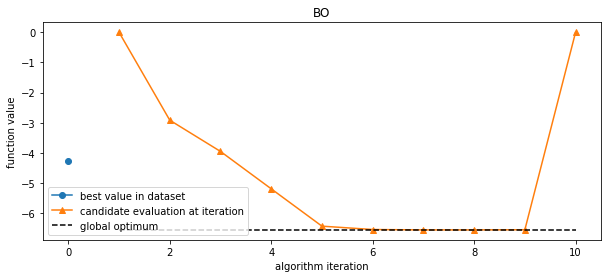

In [29]:
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 1, 1)
samples = np.arange(1, np.size(ybo)-INIT_SAMPLES+1, 1)
ax.plot(0, np.amin(ybo[:INIT_SAMPLES]), marker="o", label="best value in dataset")
ax.plot(samples, ybo[INIT_SAMPLES:], marker="^", label="candidate evaluation at iteration")
ax.hlines(-6.551, samples[0], samples[-1], label="global optimum", ls = "--", color='black')
ax.set_title('BO')
ax.set_xlabel('algorithm iteration')
ax.set_ylabel('function value')
plt.legend()